# 02 Huia Experience Training

# Setup 
## Install Tensorflow 2 Nightly and other Libraries

In [1]:
#!pip install opencv-python
#!pip install scipy
#!pip install sklearn
#!pip install pathlib
#!pip install matplotlib
#!pip install fastai=1.0.52
#!conda install cudatoolkit=10.0
#!pip install scikit-learn

# Tensorflow 2 Alpha
#!pip install tensorflow-gpu==2.0.0-alpha0 

# Tensorflow 2 Nightly 
#!pip install tf-nightly-gpu-2.0-preview --upgrade --force-reinstall

#tf addons only works with alpha for now, don't use
#!pip install tensorflow-addons


#list versions of tensorflow related files
!pip freeze | egrep 'tensor|tb|tf|numpy'

# clear tensorboard logs
!rm -rf ./logs/*

numpy==1.16.3
tb-nightly==1.14.0a20190522
tensorboardX==1.6
tensorflow-estimator-2.0-preview==1.14.0.dev2019052200
tensorflow-hub==0.3.0
tensorflowjs==1.0.1
tf-nightly-gpu-2.0-preview==2.0.0.dev20190522


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
#import tensorflowjs as tfjs
import pathlib
import os
import random
#import tensorflow_addons as tfa # not used for now as it is incompatible with tf.data.Dataset

# enable logging to make sure we are running on the GPU
tf.debugging.set_log_device_placement(True)

# check tensorflow version
tf.__version__

'2.0.0-dev20190522'

In [4]:

# clear any active session
tf.keras.backend.clear_session()

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 48

# Data
We have to understand well our data as this is fundamental to achieve good results.

In [5]:
root_path = pathlib.Path("./training_data/")
image_path = root_path /"images"
json_path = root_path /"json"
augmented_path = root_path/"augmented_imgs"

image_path,json_path ,augmented_path

(PosixPath('training_data/images'),
 PosixPath('training_data/json'),
 PosixPath('training_data/augmented_imgs'))

In [6]:
# lets set the random seed so we can reproduce our results
random.seed(7)

# get filenames from directories 
all_image_paths = list(image_path.glob('*.png')) + list(augmented_path.glob('*.png'))
#all_json_paths = list(json_path.glob('*.json'))

all_image_paths = [str(path) for path in all_image_paths] # convert to strings
random.shuffle(all_image_paths) # randomize

In [7]:
len(all_image_paths)#, len(all_json_paths)

4191

In [8]:
all_image_paths[:20] 

['training_data/augmented_imgs/moonwalk_86998.png',
 'training_data/augmented_imgs/normal_19994.png',
 'training_data/augmented_imgs/hadouken_518991.png',
 'training_data/augmented_imgs/backpack_1240991.png',
 'training_data/augmented_imgs/moonwalk_74990.png',
 'training_data/augmented_imgs/moonwalk_1230992.png',
 'training_data/augmented_imgs/underarm_872990.png',
 'training_data/augmented_imgs/underarm_247991.png',
 'training_data/augmented_imgs/normal_1203996.png',
 'training_data/images/fly_52.png',
 'training_data/augmented_imgs/fly_430991.png',
 'training_data/augmented_imgs/normal_2997.png',
 'training_data/augmented_imgs/normal_810994.png',
 'training_data/augmented_imgs/hadouken_1237999.png',
 'training_data/augmented_imgs/fly_48998.png',
 'training_data/augmented_imgs/hadouken_1238992.png',
 'training_data/augmented_imgs/backpack_1247992.png',
 'training_data/augmented_imgs/dramatic_940994.png',
 'training_data/augmented_imgs/moonwalk_74995.png',
 'training_data/augmented_img

In [9]:
import re
# extract categories for classification
pat = r'/([^/]+)_\d+.png$'
all_image_labels = [str(re.search(pat,str(image)).group(1)).lower() for image in all_image_paths]
len(all_image_labels)

4191

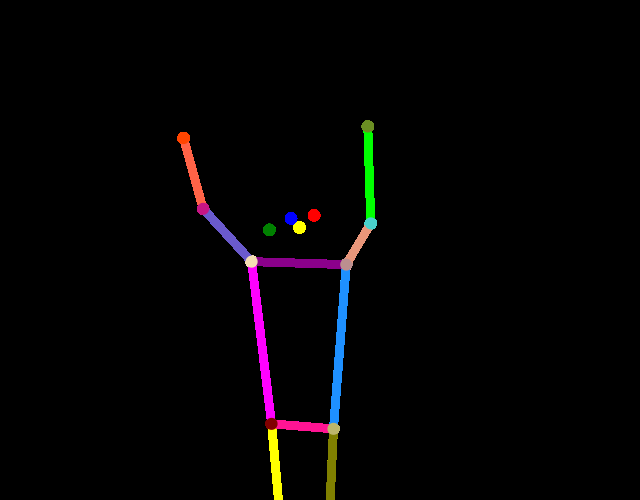

file: training_data/augmented_imgs/fly_858997.png


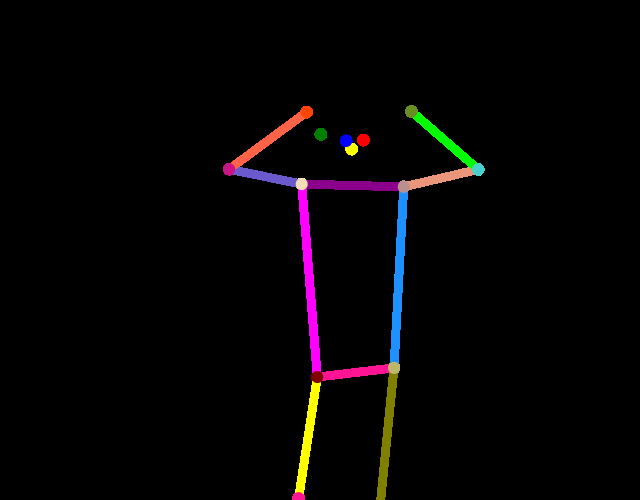

file: training_data/augmented_imgs/dramatic_126996.png


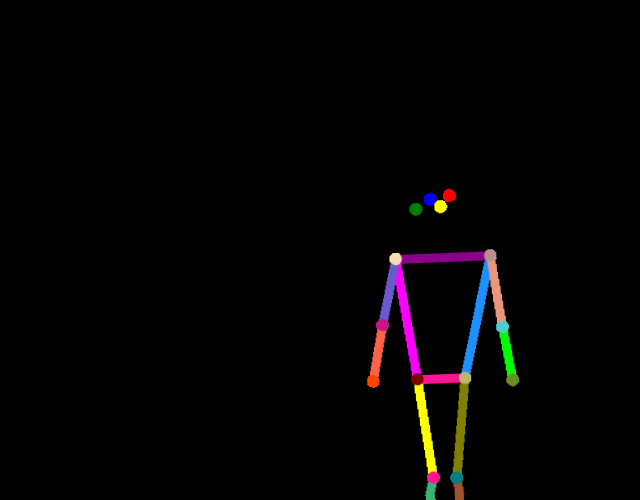

file: training_data/augmented_imgs/normal_814997.png


In [10]:
import IPython.display as display
import matplotlib.pyplot as plt

# lets check samples of our images to see what they look like
for n in range(3):  
    image = random.choice(all_image_paths)
    display.display(display.Image(str(image)))
    print(f"file: {image}")

In [11]:
# get unique classes
huia_person=[]
for label in all_image_labels:
    if label not in huia_person:
        huia_person.append(label)
huia_person = sorted(huia_person) # sort label list
huia_person

['backpack',
 'dramatic',
 'fly',
 'hadouken',
 'moonwalk',
 'normal',
 'underarm',
 'wings']

In [12]:
# put them in a dict for lookup
label_to_index = dict((name, index) for index,name in enumerate(huia_person))
label_to_index

{'backpack': 0,
 'dramatic': 1,
 'fly': 2,
 'hadouken': 3,
 'moonwalk': 4,
 'normal': 5,
 'underarm': 6,
 'wings': 7}

In [13]:
# lets format it, so we can copy and paste the dict direclty into javascript :-)
print("POSE_CLASSES = {")
for index,name in enumerate(huia_person):
    print("\t" +str(index)+": '"+name+"',")
print("}")

POSE_CLASSES = {
	0: 'backpack',
	1: 'dramatic',
	2: 'fly',
	3: 'hadouken',
	4: 'moonwalk',
	5: 'normal',
	6: 'underarm',
	7: 'wings',
}


Executing op ReadFile in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Substr in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DecodePng in device /job:localhost/replica:0/task:0/device:CPU:0
(500, 640, 3)
<dtype: 'uint8'>


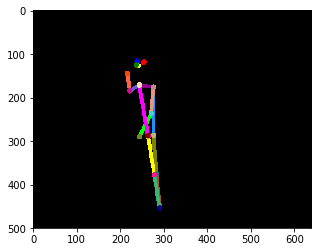

In [14]:
# load data into tf data
img_raw = tf.io.read_file(all_image_paths[0])
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)
plt.imshow(img_tensor)

#img_raw.numpy()




In [15]:
import numpy
from random import randint
import math

#@tf.function
def  preprocess_image(image):
    #print("EagerMode:" + str(tf.executing_eagerly()))
    # decode PNG
    image = tf.image.decode_png(image, channels=3)    
    
    # data augmentation - doing statically via fastai, as tensorflow addons is not compatible with graph mode yet 
    # rotate random
    #degrees = random.randint(-6,6)
    #angle = degrees * math.pi / 180
    #image = tfa.image.rotate(image,angle,interpolation='BILINEAR')
    # comented as this is not supported in graph mode yet
    
    # random crop - images are tensors of shape (500,640,3)
    #crop_factor = (random.randint(0,20)/100) # generate numbers between 0.7 and 1.0
    #new_width = int(640 * (1-crop_factor))
    #new_height = int(500 * (1-crop_factor))
    # resize_image_with_crop_or_pad
    # image = tf.image.resize_image_with_crop_or_pad(image,new_height,new_width)
    # commented as we are doing prepocessing on static files
    
    # resize
    image = tf.image.resize(image, [224, 224])

    # normalize = convert to [-1:1]    
    offset = 127.5
    image = (image-offset)/offset
    return image

#@tf.function
def load_and_preprocess_image(path):    
    image = tf.io.read_file(path)
    return preprocess_image(image)


Executing op DecodePng in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ResizeBilinear in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0


W0522 22:26:59.800251 139832576722752 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


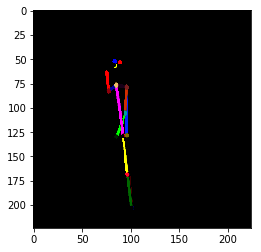

In [16]:
# load data into tf data
img_tensor = load_and_preprocess_image(all_image_paths[0])
plt.imshow(img_tensor)

In [17]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds

next(iter(path_ds))

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


<tf.Tensor: id=44, shape=(), dtype=string, numpy=b'training_data/augmented_imgs/moonwalk_86998.png'>

In [18]:
# force non performatic eager mode as tfa.image doesn't support graph mode yet
#image_ds = path_ds.map(lambda path: tf.py_function(func=load_and_preprocess_image,inp=[path],Tout=tf.float32))
image_ds = path_ds.map(map_func=load_and_preprocess_image,num_parallel_calls = AUTOTUNE)#.cache(filename='images_normalized')

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [19]:
all_image_labels_idx = [label_to_index[label] for label in all_image_labels]
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_idx, tf.int64))
len(all_image_labels)

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


4191

In [20]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds
image_count = len(all_image_labels)

type(image_label_ds)

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0


tensorflow.python.data.ops.dataset_ops.ZipDataset

In [21]:
ds = image_label_ds #.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

W0522 22:26:59.989005 139832576722752 deprecation.py:323] From <ipython-input-21-36ac9e0ee748>:2: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


Executing op ShuffleAndRepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [22]:
# we will use a pretrained mobilenet for transferlearning
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
mobilenet.trainable = False
mobilenet.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/repli

block_6_expand_relu (ReLU)      (None, 28, 28, 192)  0           block_6_expand_BN[0][0]          
__________________________________________________________________________________________________
block_6_pad (ZeroPadding2D)     (None, 29, 29, 192)  0           block_6_expand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_pr

Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


In [23]:
image_batch, label_batch = next(iter(ds))
print(image_batch.shape)

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
(48, 224, 224, 3)


In [24]:
label_batch[0].numpy()
image_batch[0].numpy()

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0


array([[[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       ...,

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]]

In [25]:
image_batch, label_batch = next(iter(ds))

feature_map_batch = mobilenet(image_batch)
print(feature_map_batch.shape)

Executing op Pad in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNorm in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu6 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DepthwiseConv2dNative in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DepthwiseConv2dNative in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
(48, 7, 7, 1280)


In [26]:
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu',bias_initializer=tf.keras.initializers.he_normal(),name='features'),
    tf.keras.layers.Dense(len(huia_person),activation='softmax'),
])
model.summary()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
______

In [27]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Softmax in device /job:localhost/replica:0/task:0/device:GPU:0
min logit: 0.055411372
max logit: 0.25408116

Shape: (48, 8)


In [28]:
len(model.trainable_variables) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [29]:
steps_per_epoch=tf.math.ceil((len(all_image_paths)-838)/BATCH_SIZE).numpy()
steps_per_epoch

Executing op Ceil in device /job:localhost/replica:0/task:0/device:GPU:0


70.0

In [30]:
# One Cycle https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras
# import OneCycleLR
from datetime import datetime
now = datetime.now()



log_dir = "./logs/step_1_" + now.strftime("%Y%m%d-%H%M%S") + "/"

callbacks = []

# logging
tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
tbCallback.set_model(model)
callbacks.append(tbCallback)

epochs = 20
max_lr = 3e-4

base_lr = max_lr/10
# max_m = 0.98
# base_m = 0.85

# cyclical_momentum = False
# augment = True
# cycles = 2.35

# iterations = round(len(all_image_paths)/BATCH_SIZE*epochs)
# iterations = list(range(0,iterations+1))
# step_size = len(iterations)/(cycles)

# clr = OneCycleLR.CyclicLR(base_lr=base_lr,
#                 max_lr=max_lr,
#                 step_size=step_size,
#                 max_m=max_m,
#                 base_m=base_m,
#                 cyclical_momentum=cyclical_momentum)

#callbacks.append(clr)

# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy')>0.9):
#       print("\nReached 60% accuracy so cancelling training!")
#       self.model.stop_training = True

# earlyStopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss')
# callbacks.append(earlyStopping)

# chkPoint = tf.keras.callbacks.ModelCheckpoint('./models.h5')
# chkPoint.set_model(model)
# callbacks.append(chkPoint)

Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteGraphSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0


In [31]:
# skip 20% validation images
test_dataset = ds.take(838) 
train_dataset = ds.skip(838)

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [32]:
mobilenet.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [33]:
start = datetime.now()
history = model.fit(train_dataset, epochs=epochs,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)
end = datetime.now()
print(f"total time of {end-start} for {epochs} epochs, tensorflow version={tf.__version__}")

Executing op CloseSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/20
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0


W0522 22:27:32.037099 139832576722752 deprecation.py:323] From /home/ale/anaconda3/envs/tensor20/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/repli

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


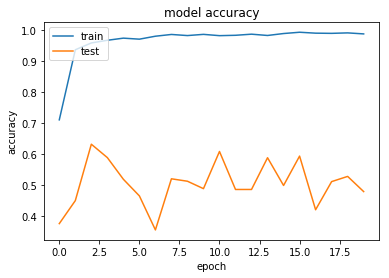

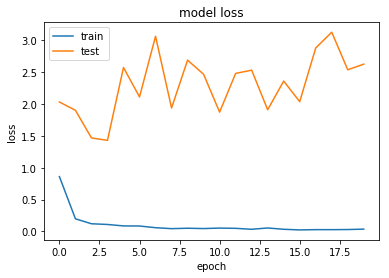

In [34]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
#!pip install scikit-learn

In [36]:
from datetime import datetime
import OneCycleLR
now = datetime.now()
log_dir = "./logs/step_2_" + now.strftime("%Y%m%d-%H%M%S") + "/"

callbacks = []

epochs = 50
max_lr = 3e-6

# base_lr = max_lr/10
# max_m = 0.98
# base_m = 0.85

# cyclical_momentum = False
# augment = True
# cycles = 2.35

# iterations = round(len(all_image_paths)/BATCH_SIZE*epochs)
# iterations = list(range(0,iterations+1))
# step_size = len(iterations)/(cycles)

# clr = OneCycleLR.CyclicLR(base_lr=base_lr,
#                 max_lr=max_lr,
#                 step_size=step_size,
#                 max_m=max_m,
#                 base_m=base_m,
#                 cyclical_momentum=cyclical_momentum)

#callbacks.append(clr)

# logging
tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
tbCallback.set_model(model)
callbacks.append(tbCallback)

In [37]:
mobilenet.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [38]:
history = model.fit(train_dataset, epochs=epochs,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/50
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in d

Epoch 34/50
70/70 [==============================] - 56s 795ms/step - loss: 5.8342e-04 - accuracy: 1.0000 - val_loss: 0.0807 - val_accuracy: 0.9714
Epoch 35/50
70/70 [==============================] - 56s 795ms/step - loss: 0.0014 - accuracy: 0.9991 - val_loss: 0.0803 - val_accuracy: 0.9745
Epoch 36/50
70/70 [==============================] - 56s 794ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0752 - val_accuracy: 0.9766
Epoch 37/50
70/70 [==============================] - 56s 793ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0698 - val_accuracy: 0.9769
Epoch 38/50
70/70 [==============================] - 56s 795ms/step - loss: 3.3883e-04 - accuracy: 1.0000 - val_loss: 0.0671 - val_accuracy: 0.9780
Epoch 39/50
70/70 [==============================] - 56s 798ms/step - loss: 3.4425e-04 - accuracy: 1.0000 - val_loss: 0.0616 - val_accuracy: 0.9789
Epoch 40/50
70/70 [==============================] - 55s 792ms/step - loss: 7.7994e-04 - accuracy: 1.0000 - val_loss: 0.0559

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


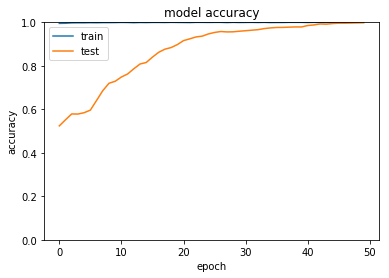

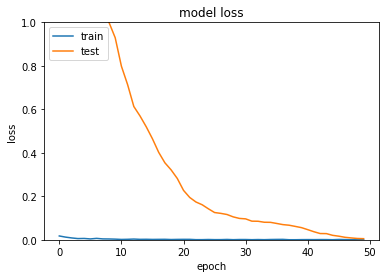

In [39]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0, 1) 
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(0, 1) 
plt.show()

In [44]:
model.save("models/huia_poses_final.h5") # 1.0

In [41]:
model

# Convert to TENSORFLOW JS / Quantization

In [42]:
!pip freeze 
#!pip install tensorflowjs==0.6.4 --force-reinstall


absl-py==0.7.1
astor==0.8.0
attrs==19.1.0
backcall==0.1.0
beautifulsoup4==4.7.1
bleach==3.1.0
blis==0.2.4
Bottleneck==1.2.1
certifi==2019.3.9
cffi==1.12.3
chardet==3.0.4
cycler==0.10.0
cymem==2.0.2
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
fastai==1.0.51
fastprogress==0.1.21
ffmpeg==1.4
ffmpeg-python==0.1.17
future==0.17.1
gast==0.2.2
google-pasta==0.1.6
grpcio==1.20.1
h5py==2.9.0
idna==2.8
ipykernel==5.1.0
ipython==7.5.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
jedi==0.13.3
Jinja2==2.10.1
joblib==0.13.2
jsonschema==3.0.1
jupyter==1.0.0
jupyter-client==5.2.4
jupyter-console==6.0.0
jupyter-core==4.4.0
jupyterlab==0.35.6
jupyterlab-server==0.2.0
Keras==2.2.4
Keras-Applications==1.0.7
Keras-Preprocessing==1.0.9
kiwisolver==1.1.0
Markdown==3.1.1
MarkupSafe==1.1.1
matplotlib==3.0.3
mistune==0.8.4
mkl-fft==1.0.12
mkl-random==1.0.2
mock==3.0.5
murmurhash==1.0.2
nb-conda==2.2.1
nb-conda-kernels==2.2.1
nbconvert==5.5.0
nbformat==4.4.0
notebook==5.7.8
numexpr==2.6.9
numpy==1.16.3
nvid

In [50]:
# Tensorflow 2 Alpha has a bug exporting to TFJS, so we need to use a nightly version
import tensorflowjs as tfjs
import numpy as np

# model = tf.keras.models.load_model("models/huia_mob_224_final_one_cycle.h5")
# model.load_weights("models/huia_mob_224_final_one_cycle.h5")

#tfjs.converters.save_keras_model(model, "models_tfjs/huia_poses_final_q8ale",quantization_dtype=np.uint8)
tfjs.converters.save_keras_model(model, "models_tfjs/huia_poses_final_q16ale",quantization_dtype=np.uint16)

# run on command line, above commands are buggy at the moment
# !tensorflowjs_converter \
#     --input_format=keras \
#     --output_format=tfjs_layers_model \
#     ./models/huia_poses_final.h5 \
#     ./models_tfjs/huia_poses_final_8b \
#     --quantization_bytes 1

# !tensorflowjs_converter \
#     --input_format=keras \
#     --output_format=tfjs_layers_model \
#     ./models/huia_poses_final.h5 \
#     ./models_tfjs/huia_poses_final_16b \
#     --quantization_bytes 2

# !tensorflowjs_converter \
#     --input_format=tfjs_layers_model \
#     --output_format=tfjs_layers_model \
#     ./tfjs_poses/model.json \
#     ./tfjs_poses_q1 \
#     --quantization_bytes 1

# tensorflowjs_converter \
#    --input_format=tfjs_layers_model \
#    --output_format=tfjs_layers_model \
#    --quantization_bytes=1 \
#    huia_poses_final_16b/model.json \
#    huia_poses_final_16b8

# copy tfjs model to 03_experience/static and change App.vue reference to load it

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [ ]:
tf.keras.utils.plot_model(model,'model.png',show_layer_names=False) #,show_shapes=True)

# Tensorboard Visualization

In [51]:
# https://www.tensorflow.org/tensorboard/
import tensorboard as tb
%load_ext tensorboard
#%load_ext tensorboard.notebook
%tensorboard --logdir ./logs
#notebook.list() # View open TensorBoard instances
#notebook.display(port=6006, height=1000)
#!kill 25264

Reusing TensorBoard on port 6006 (pid 22050), started 3:11:01 ago. (Use '!kill 22050' to kill it.)

# Test / Predict

In [ ]:
import numpy as np
sample = np.reshape(img_final,[1,224,224,3])

predict = int(model.predict_classes(sample))
predict

In [ ]:
[key for key,value in label_to_index.items() if value == predict]

In [ ]:
label_to_index

# UTILS

## Delete Images that are empty

In [ ]:
# during image capture some images are empty, so we automatically delete them

# open images and delete if they are empty
def remove_empty_imgs(imgpath):
    for item in imgpath.iterdir():
        im = imread(str(item), format='png')
        if np.count_nonzero(im)==0: 
            print(item,np.count_nonzero(im))
            os.remove(str(item))
            
#remove_empty_imgs(image_path)

## Sync JSONs with Images

In [ ]:
# since we might delete unwanted images for training, this will also delete the json files
# sync json & images 

def sync_json_images(json_paths, img_path):
    for json in json_paths:
        #print(json.stem, end=" ")
        img = img_path/f"{json.stem}.png"
        if not Path(img).exists():
            print(f"{img} doesn't exist, deleting {json}")
            Path(json).unlink()
        
#sync_json_images(all_json_paths, image_path)

# Static Data Augmentation
Decided to use FASTAI to statically preprocess data augmentation, as tensorflow addons (0.3.1) still didn't support graph mode and is therefore not compatible with tf.data.Dataset mappings




In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from random import randint
import pathlib

root_path = pathlib.Path("./training_data/")
save_fast = Path('./training_data/augmented_imgs/')
save_fast.mkdir(parents=True, exist_ok=True)

tfms = get_transforms(do_flip=False, 
                            flip_vert=False, 
                            max_rotate=6, 
                            max_zoom=1.2, 
                            max_lighting=None, 
                            max_warp=0.2, 
                            p_affine=0.2, 
                            p_lighting=0)


image_path = root_path /"images"
all_image_paths = list(image_path.glob('*.png'))


def generate_augmented(qty):
    for f in all_image_paths:
        image = open_image(f)
        for i in range(0,qty):
            image_fast = image.apply_tfms(tfms[0])
            save_name = str(save_fast) + '/' + f.stem + '99' + str(i) + f.suffix
            print(save_name)
            image_fast.save(save_name)

#generate 10 variations of each image
#generate_augmented(10)